# Présentation du dataset et de la problématique

# Programmation

### Libraries utilisées

In [24]:
%pip install reservoirpy
%pip install matplotlib
%pip install pandas
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### Transformation des données

La première étape est de transformer les données du dataset en data d'entraînement et de test pour notre modèle.
Cette première fonction renvoie un dictionnaire contenant les timeframes, et pour chacune d'elle les informations "x","y" et "action" pour chaque souris à l'image.

In [4]:
import pandas as pd
from pygame_display import *

def import_data(dataset_name, dataset_sample):
    data_tracking = pd.read_parquet("data/train_tracking/"+dataset_name+"/"+dataset_sample+".parquet")
    data_annotation = pd.read_parquet("data/train_annotation/"+dataset_name+"/"+dataset_sample+".parquet")

    N_TIMEFRAME = 10000

    timeframes = {}
    for index, row in data_tracking.iterrows():
        if row.video_frame > N_TIMEFRAME :
            break
        if row.bodypart == "body_center":
            data = {"x": row.x, "y": row.y,"action":"None"}
            if row.video_frame not in timeframes :
                timeframes[row.video_frame] = {}
            timeframes[row.video_frame][row.mouse_id] = data

    #all_actions = []
    for index, row in data_annotation.iterrows():
        #if row.action not in all_actions :
        #    all_actions.append(row.action)
        if row.start_frame > N_TIMEFRAME :
            break
        for frame in range(row.start_frame, row.stop_frame+1):
            if frame in timeframes : 
                if row.agent_id in timeframes[frame]:
                    timeframes[frame][row.agent_id]['action'] = row.action
    return timeframes

pygame 2.6.1 (SDL 2.28.4, Python 3.13.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [5]:
AdaptableSnail_dataset = import_data("AdaptableSnail", "44566106")

### Affichage d'une simulation

Nous avons également codé une fonction qui lance une interface utilisant pygame pour simuler les souris, leurs déplacements et leurs actions.

In [6]:
import pygame
import random
import csv

def find_dimensions(dataset_name, sample_name):
    print("Récupération des dimensions de la vidéo")
    with open("data/train.csv", newline="", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for i, row in enumerate(reader):
            if row["lab_id"]==dataset_name and row["video_id"]==sample_name :
                return row["video_width_pix"], row["video_height_pix"]

    print ("Les dimensions n'ont pas été trouvées, 1280 x 720 appliqué")
    return 1280, 720  

def display(data, dataset_name, sample_name) :
    action_colors = {
    "None":(0,0,0),
    "rear": (128, 0, 128),        # violet
    "avoid": (0, 128, 255),       # bleu clair
    "attack": (255, 0, 0),        # rouge
    "approach": (0, 200, 0),      # vert
    "chase": (255, 165, 0),       # orange
    "submit": (100, 100, 100),    # gris
    "chaseattack": (0, 0, 0)      # noir
    }
    
    pygame.init()
    width, height = find_dimensions(dataset_name, sample_name)

    screen = pygame.display.set_mode((720, 480), pygame.RESIZABLE)
    clock = pygame.time.Clock()

    surface = pygame.Surface((int(width), int(height)))

    running = True
    for frame in data.values() :
        if not running :
            break
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

        surface.fill((255, 255, 255))  # fond blanc
        clock.tick(25)
        for agent_id in frame.values() :
            color = (0, 0, 0)
            if agent_id["action"] is not None :
                color = action_colors[agent_id["action"]]
            pygame.draw.circle(surface, color, (int(agent_id['x']), int(agent_id['y'])), 20)

        font = pygame.font.SysFont(None, 60)
        y = 0
        for key,value in action_colors.items():
            text = font.render(key, True, value)
            surface.blit(text, (10, 10 + y))
            y += 35

        # adaptation écran
        scaled = pygame.transform.smoothscale(surface, screen.get_size())
        screen.blit(scaled, (0, 0))

        pygame.display.flip()
        clock.tick(25)  # fps

    pygame.quit()

In [7]:
display(AdaptableSnail_dataset, "AdaptableSnail", "44566106")

Récupération des dimensions de la vidéo


Nous transformons maintenant ce dictionnaire de données en sets de données d'entraînement et de test de notre modèle.
Une timeframe contient comme information les coordonnées de chaque souris, c'est-à-dire un vecteur de taille 8 (x et y des 4 souris). L'objectif (Y) est de deviner l'action qu'effectue la souris 1. (vecteur de taille len(actions))

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from reservoirpy.nodes import Reservoir, Ridge, Input
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder() #Car les actions doivent être représentées des entiers
actions = ["None", "rear", "avoid", "attack", "approach", "chase", "submit", "chaseattack"]
le.fit(actions)

LabelEncoder()

In [10]:
def data_to_array(data):
    X = []
    Y = []
    for timeframe in sorted(data.keys()):
        vector = []
        for mice_id in range(1,5):
            if mice_id in data[timeframe]:
                infos = data[timeframe][mice_id]
                vector.append(infos["x"])
                vector.append(infos["y"])      
            else :
                vector.append(0)
                vector.append(0)
        X.append(vector)
        if 1 in data[timeframe]:
            Y.append(data[timeframe][1]["action"])
        else :
            Y.append("None")
    return X, le.transform(Y)

def pred_to_vector(Y):
    new_Y = []
    for pred in Y :
        v =np.zeros(len(actions)).reshape(1, -1)
        v[0][pred] = 1
        new_Y.append(v)
    return new_Y
        
def make_windows(X, Y, N):
    X_seq = []
    Y_seq = []

    for i in range(len(X) - N):
        X_seq.append(X[i:i+N])
        Y_seq.append(Y[i+N])

    return X_seq, Y_seq

## Entraînement et résultats du model

Puis nous pouvons essayer sur des paramètres explicités nos prédictions.

In [14]:

X, Y = data_to_array(AdaptableSnail_dataset)

X = np.array(X)
Y = np.array(pred_to_vector(Y))
print(Y.shape)

N = 200
X_seq, Y_seq = make_windows(X, Y, N)

split_ratio = 0.8
split_index = int(len(X_seq) * split_ratio)

X_train = X_seq[:split_index]
Y_train = Y_seq[:split_index]

X_test = X_seq[split_index:]
Y_test = Y_seq[split_index:]

"""
print(len(X_train))        # nb de séquences
print(X_train[0].shape)   # (N, D)
print(len(Y_train))   # (N, D)
print(Y_train[0].shape)         # int (label)
"""

def manual_testing(units, sr, lr, input_scaling):
    # Création du modèle
    source = Input()
    reservoir = Reservoir(
        units=units,
        sr= sr,
        lr= lr,
        input_scaling=input_scaling
    )
    readout = Ridge(ridge=0.045077102892478675)
    model = source >> reservoir >> readout

    states_train = []

    # Entraînement
    for i,x in enumerate(X_train):
        print(f"\rEntraînement en cours : {i} / {len(X_train)}", end="")
        states = reservoir.run(x)
        reservoir.reset()
        states_train.append(states[-1, np.newaxis])

    readout.fit(states_train, Y_train)

    Y_pred = []
    print("")
    for i,x in enumerate(X_test):
        print(f"\rTests en cours : {i} / {len(X_test)}", end="")
        states = reservoir.run(x)
        reservoir.reset()
        y = readout.run(states[-1, np.newaxis])
        Y_pred.append(y)

    Y_pred_class = [np.argmax(y_p) for y_p in Y_pred]
    Y_test_class = [np.argmax(y_t) for y_t in Y_test]

    score = accuracy_score(Y_test_class, Y_pred_class)
    print("")
    print("précision : ", f"{score * 100:.3f} %")
    return Y_pred_class, Y_test_class



(10001, 1, 8)


## Calibration optimisée des hyper-paramètres
L'objecif finale est de calibrer les hyper-paramètres afin d'optimiser les résultats. Pour cela, nous prossédons comme dans le tutoriel de la librairie.

In [ ]:
from reservoirpy.observables import nrmse, rsquare

# Objective functions accepted by ReservoirPy must respect some conventions:
#  - dataset and config arguments are mandatory, like the empty '*' expression.
#  - all parameters that will be used during the search must be placed after the *.
#  - the function must return a dict with at least a 'loss' key containing the result of the loss function.
# You can add any additional metrics or information with other keys in the dict. See hyperopt documentation for more informations.
def objective(dataset, config, *, input_scaling, N, sr, lr, ridge, seed):
    # This step may vary depending on what you put inside 'dataset'
    x_train, x_test, y_train, y_test = dataset

    # You can access anything you put in the config file from the 'config' parameter.
    instances = config["instances_per_trial"]

    # The seed should be changed across the instances to be sure there is no bias in the results due to initialization.
    variable_seed = seed

    losses = []; r2s = [];
    for n in range(instances):
        # Build your model given the input parameters
        source = Input()
        reservoir = Reservoir(
            units=N,
            sr=sr,
            lr=lr,
            input_scaling=input_scaling,
            seed=variable_seed
        )
        readout = Ridge(ridge=1e-5)

        model = source >> reservoir >> readout

        states_train = []
        for i,x in enumerate(X_train):
            states = reservoir.run(x)
            reservoir.reset()
            states_train.append(states[-1, np.newaxis])

        readout.fit(states_train, Y_train)

        Y_pred = []
        for i,x in enumerate(x_test):
            states = reservoir.run(x)
            reservoir.reset()
            y = readout.run(states[-1, np.newaxis])
            Y_pred.append(y)

        Y_pred_class = [np.argmax(y_p) for y_p in Y_pred]
        Y_test_class = [np.argmax(y_t) for y_t in Y_test]

        score = accuracy_score(Y_test_class, Y_pred_class)

        loss = nrmse(y_test, Y_pred, norm_value=np.ptp(x_train))
        r2 = rsquare(y_test, Y_pred)

        # Change the seed between instances
        variable_seed += 1

        losses.append(loss)
        r2s.append(r2)

    # Return a dictionnary of metrics. The 'loss' key is mandatory when using hyperopt.
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}

import json

hyperopt_config = {
    "exp": "hyperopt-multiscroll",    # the experimentation name
    "hp_max_evals": 50,              # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",            # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                       # the random state seed, to ensure reproducibility
    "instances_per_trial": 2,         # how many random ESN will be tried with each sets of parameters
    "hp_space": {                     # what are the ranges of parameters explored
        "N": ["randint",100, 500],             # the number of neurons is fixed to 500
        "sr": ["loguniform", 1e-2, 1e1],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "lr": ["loguniform", 1e-2, 1e0],    # idem with the leaking rate, from 1e-3 to 1
        "input_scaling": ["loguniform", 1e-1, 1e1], # the input scaling is fixed
        "ridge": ["loguniform", 1e-6, 1e1],        # and so is the regularization parameter.
        "seed": ["choice", 1234]          # an other random seed for the ESN initialization
    }
}

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

dataset = (X_train, X_test, Y_train, Y_test)
from reservoirpy.hyper import parallel_research
best = parallel_research(objective, dataset, f"{hyperopt_config['exp']}.config.json", ".")

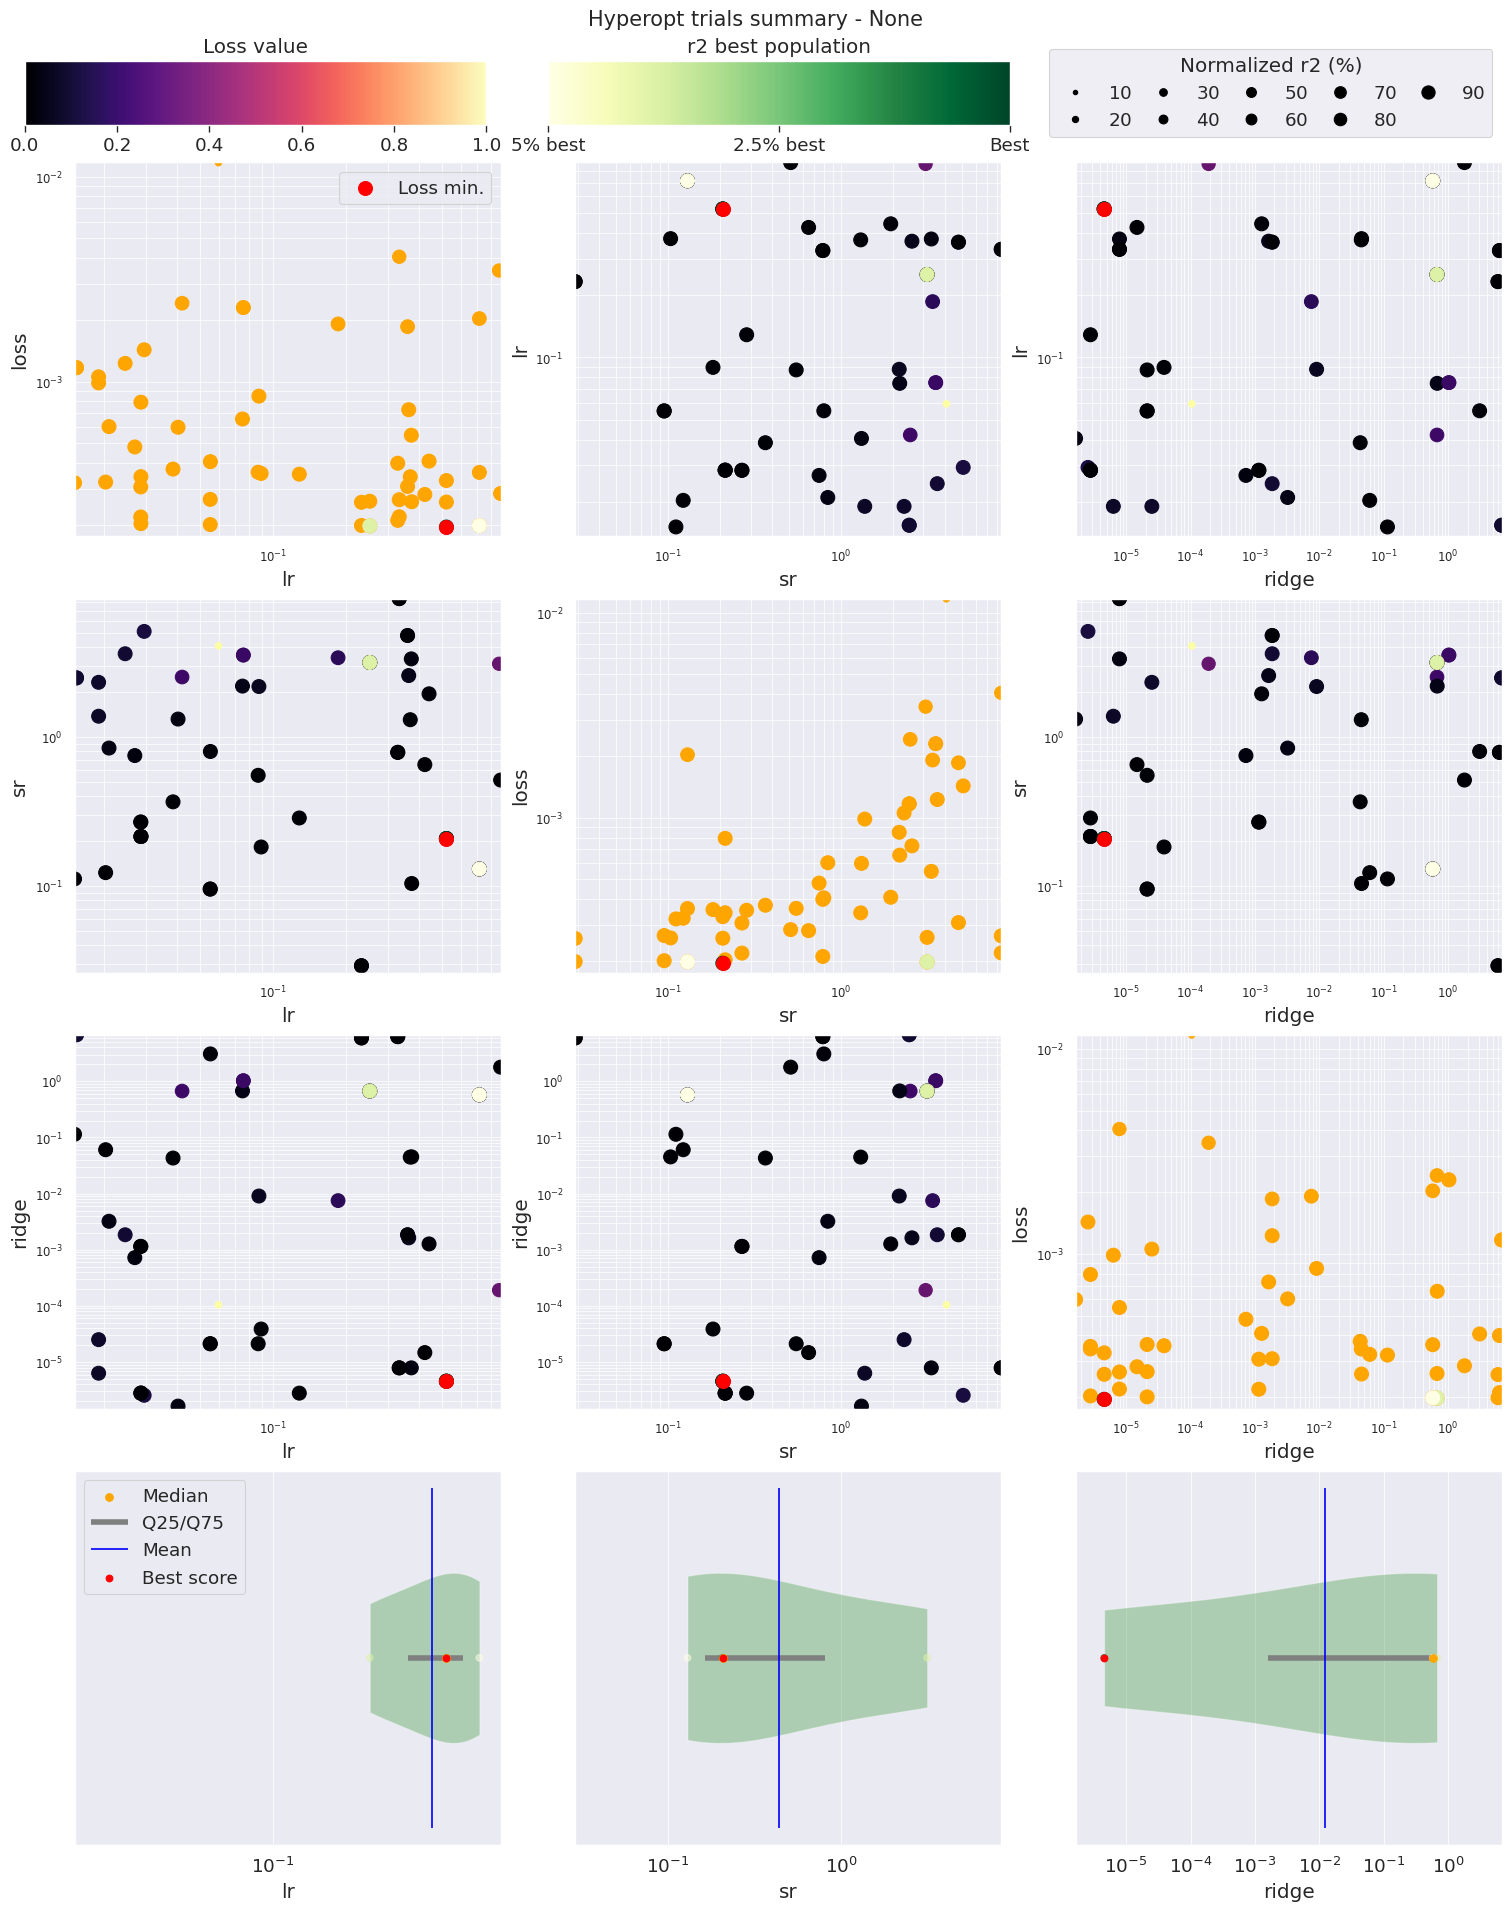

In [ ]:
from reservoirpy.hyper import plot_hyperopt_report
fig = plot_hyperopt_report(hyperopt_config["exp"], ("lr", "sr", "ridge"), metric="r2")

Finalement, nous extractons les valeurs qui donnent la meilleure loss. 

In [ ]:
import json
import os

result_list = os.listdir("hyperopt-multiscroll/results")
best_json_loss = 1
best_json = None
for res in result_list:
  with open(f"hyperopt-multiscroll/results/{res}") as f:
    data = json.load(f)
    if data['returned_dict']['loss'] < best_json_loss :
      best_json_loss = data['returned_dict']['loss']
      best_json = data
print(best_json)

{'returned_dict': {'loss': 0.00019528984040737945, 'r2': 0.5047740025230141, 'status': 'ok', 'start_time': 1768163088.9295387, 'duration': 46.32287621498108}, 'current_params': {'N': 18, 'sr': 0.20731719263694534, 'lr': 0.5214297905300547, 'input_scaling': 2.4816244430149865, 'ridge': 4.562905088129699e-06, 'seed': 1234}}


In [18]:

Y_pred_class, Y_test_class = manual_testing(300, 0.0290314, 0.232326, 1)
results = np.zeros((8, 8), dtype=int)
for res in range(len(Y_pred_class)):
    results[Y_test_class[res]][Y_pred_class[res]] += 1

print(results)

Entraînement en cours : 7956 / 7957
Tests en cours : 1989 / 1990
précision :  71.055 %
[[1412    0    0    0    0    0   49    0]
 [  85    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [  69    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [ 373    0    0    0    0    0    2    0]
 [   0    0    0    0    0    0    0    0]]


# Conclusion
L'objectif du travail fourni est de faire deviner au modèle le comportement d'une souris, connaissant les trajectoirs temporelles de toutes les souris présentes.

### Explication des résultats
Comme nous le montre la matrice de confusion ci-dessus, les résultats ne sont pas très concluant. En effet, la majorité du temps, les souris ne font pas d'action.
En dessous d'un certain pourcentage de prédiction efficace, il sera toujours plus efficace pour le réseau de prédire l'action "None", qui donnera raison 80% des tests, que réellement prédire. C'est également pour cela que l'optimisation des hyper-paramètres nous donne un nombre optimal de neuronne dans le model relativement faible (54). Avec des plages d'hyper-paramètres plus grandes et plus d'échantillonage, il y aurait la possibilité de deviner d'obtenir un modèle qui, en plus de détecter l'absence d'action, détecter quelques actions réalisées, et dépasserait la précision actuelle. Nous avons également quelques réseaux possèdant plusieurs centaines de couches qui ont réussi à prédire quelques actions, mais qui, au contraire, prédissait parfois des actions quand il n'y en avait pas. Avec plus de temps, nous aurions peut-être réussis à trouver une balance entre ces 2 modèles.

Pour ce qui est des autres hyper-paramètres, la figure générée par l'optimisation montre que le leaking rate (lr) et le ridge n'ont pas beaucoup d'influence. Nous pouvons cependant observer une corrélation entre la loss et le spectral radius (rs) : plus ce dernier est faible, plus la loss diminue.

Il faut néanmoins considérer cette conclusion avec précaution : tout comme un nombre de neuronne bas indique une meilleur précision mais "bloque" celle-ci à un certain pourcentage correspondant au nombre d'actions nulles, diminuer le spectral radius rend le système plus stable, ce qui le pousse probablement à toujours proposer une action nulle, ce qui nous interesse pas ici.

### Perspectives d'évolutions

Une manière de résoudre le problème est d'essayer un entraînement plus poussé, sur des séquences différentes (et pas juste une fenêtre coulissante comme ici), un grand nombre de neuronne et beaucoup de temps d'entraînement.
Un essai a également était effectué avec plus de paramètre en entrée que les coordonnées des souris, mais par manque de capacité d'entraînement du modèle, ce modèle n'a pas donné de résultats concluants.

Une autre solution est de couper une partie des passages où il n'y a pas d'actions pour se concentrer sur celles où il est possible de chercher uen corrélation entre caractéristiques et actions.

Nous avons probablement sur-évalués notre sujet, mais cela nous a permis de mieux comprendre le fonctionnement de la librairie et de ces capacité, je reste néanmoins sceptique sur l'utilisation seule d'ESN pour résoudre la problématique posée.